In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library Imports

In [2]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=924bf5024d61ce5d8b5d3f397e302040dadf45354ec050138b22bda383eb2d98
  Stored in directory: /root/.cache/pip/wheels/15/0c/b3/674aea8c5d91c642c817d4d630bd58faa316724b136844094d
Successfully built utils


In [3]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4111    0  4111    0     0  18687      0 --:--:-- --:--:-- --:--:-- 18686
100  517k  100  517k    0     0   611k      0 --:--:-- --:--:-- --:--:--  611k
--2025-07-12 19:25:55--  https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
Resolving anaconda.org (anaconda.org)... 104.19.144.37, 104.19.145.37, 2606:4700::6813:9125, ...
Connecting to anaconda.org (anaconda.org)|104.19.144.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5f738b4b78d4370a69f82984/673b62920c609ff6945bb24d?response-content-disposition=attachment%3B%20filename%3D%22ta-lib-0.5.1-py311h9ecbd09_0.conda%22%3B%20filename%2A%3DUTF-8%27%27ta-lib-0.5.1-py311h9ecbd09_0.conda&response-content-type=application%2Foctet-stream&X-Amz-Algorithm=

In [4]:
import math
import pandas as pd
import numpy as np

from utils import *

import time
import datetime
from datetime import timezone


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_regression

import xgboost as xgb
import talib as tb

## Create DataFrame
### dataset_ex_df - BTC 5 min Dataset for 2 years 2020 Nov 1 - 2022 Oct 30

In [5]:
dataset_ex_df=pd.read_csv("/content/drive/MyDrive/tft/data/btc/btcusdt_5min_data.csv")
dataset_ex_df.head()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2023-04-30 18:30:00,29645.41,29645.51,29589.94,29607.99,92.94600,1682879699999,2.752619e+06,3068,32.84146,9.725205e+05,0
1,2023-04-30 18:35:00,29607.98,29608.97,29592.55,29601.98,147.94548,1682879999999,4.379712e+06,3061,50.10438,1.483165e+06,0
2,2023-04-30 18:40:00,29601.98,29617.73,29601.98,29616.47,56.83900,1682880299999,1.683169e+06,1960,27.66746,8.192802e+05,0
3,2023-04-30 18:45:00,29616.46,29616.47,29556.17,29597.43,181.15563,1682880599999,5.359159e+06,4618,93.44954,2.764646e+06,0
4,2023-04-30 18:50:00,29597.42,29632.18,29597.17,29606.79,89.94455,1682880899999,2.663901e+06,2612,42.41434,1.256128e+06,0


In [6]:
dataset_ex_df.shape

(210772, 12)

# Data Visualization & Preprocess

In [7]:
dataset_ex_df = dataset_ex_df.drop(columns=["ignore","close_time","number_of_trades"])

#### Add Log change and Percentage change of the Close price

In [8]:
dataset_ex_df['pct_change'] = (dataset_ex_df['close'] - dataset_ex_df['close'].shift(1))/ dataset_ex_df['close'].shift(1)
dataset_ex_df['log_change'] = np.log(dataset_ex_df['close']/ dataset_ex_df['close'].shift(1))

In [9]:
dataset_ex_df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,pct_change,log_change
0,2023-04-30 18:30:00,29645.41,29645.51,29589.94,29607.99,92.94600,2.752619e+06,32.84146,9.725205e+05,NaN,NaN
1,2023-04-30 18:35:00,29607.98,29608.97,29592.55,29601.98,147.94548,4.379712e+06,50.10438,1.483165e+06,-0.000203,-0.000203
2,2023-04-30 18:40:00,29601.98,29617.73,29601.98,29616.47,56.83900,1.683169e+06,27.66746,8.192802e+05,0.000489,0.000489
3,2023-04-30 18:45:00,29616.46,29616.47,29556.17,29597.43,181.15563,5.359159e+06,93.44954,2.764646e+06,-0.000643,-0.000643
4,2023-04-30 18:50:00,29597.42,29632.18,29597.17,29606.79,89.94455,2.663901e+06,42.41434,1.256128e+06,0.000316,0.000316


#### Unix-Date convert


In [10]:
#TWO FUNCTIONS TO MANAGE THE DATE
def unix_to_datetime(unix_time):
    return datetime.datetime.fromtimestamp(unix_time/1000)

def days_to_unix(date,numOfDays):
    date = datetime.datetime.now()
    date = date.replace(hour=0, minute=0, second=0, microsecond=0)
    date = date - datetime.timedelta(days=numOfDays)
    return int(date.timestamp()*1000)

def date_to_unix(year,month,day):
    dt =  datetime.datetime(year,month,day,0,0)
    return str(dt.replace(tzinfo=timezone.utc).timestamp())


In [11]:
dataset_ex_df

,timestamp,open,high,low,close,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,pct_change,log_change
0,2023-04-30 18:30:00,29645.41,29645.51,29589.94,29607.99,92.94600,2.752619e+06,32.84146,9.725205e+05,NaN,NaN
1,2023-04-30 18:35:00,29607.98,29608.97,29592.55,29601.98,147.94548,4.379712e+06,50.10438,1.483165e+06,-0.000203,-0.000203
2,2023-04-30 18:40:00,29601.98,29617.73,29601.98,29616.47,56.83900,1.683169e+06,27.66746,8.192802e+05,0.000489,0.000489
3,2023-04-30 18:45:00,29616.46,29616.47,29556.17,29597.43,181.15563,5.359159e+06,93.44954,2.764646e+06,-0.000643,-0.000643
4,2023-04-30 18:50:00,29597.42,29632.18,29597.17,29606.79,89.94455,2.663901e+06,42.41434,1.256128e+06,0.000316,0.000316
...,...,...,...,...,...,...,...,...,...,...,...
210767,2025-04-30 18:10:00,94282.99,94441.78,94260.86,94360.00,49.00609,4.624597e+06,22.15434,2.090860e+06,0.000817,0.000816
210768,2025-04-30 18:15:00,94360.00,94461.12,94305.58,94408.05,48.89358,4.615328e+06,24.69704,2.331215e+06,0.000509,0.000509
210769,2025-04-30 18:20:00,94408.06,94449.00,94262.29,94276.00,33.41959,3.152813e+06,17.37150,1.638917e+06,-0.001399,-0.001400
210770,2025-04-30 18:25:00,94276.00,94304.35,94159.82,94159.83,44.53979,4.196875e+06,14.74130,1.388818e+06,-0.001232,-0.001233


#### Initial Shape of the BTC Dataset

In [12]:
print('{} number of entries & {} of features in the BTC dataset.'.format(dataset_ex_df.shape[0],dataset_ex_df.shape[1]))

210772 number of entries & 11 of features in the BTC dataset.


#### Plot Function

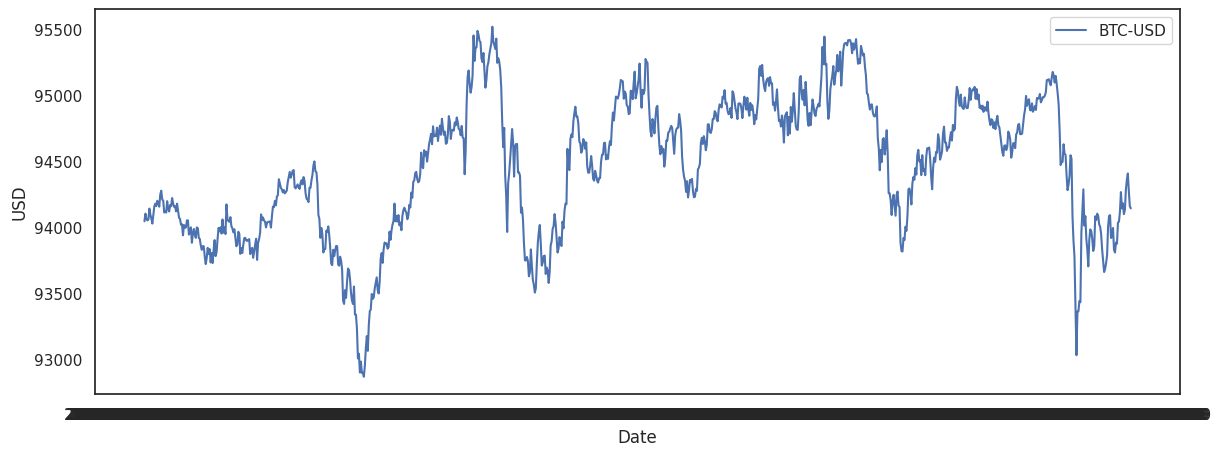

In [13]:
def plotDataset(data,x_label, y_label1,y_label2,y_name):
  plt.figure(figsize=(14, 5), dpi=100)
  plt.plot(data[x_label].tail(1000), data[y_label1].tail(1000), label='BTC-USD')
  # plt.plot(data[x_label], y_label2, label=y_name)
  plt.xlabel('Date')
  plt.ylabel('USD')
  # plt.title('Figure 2: BTC-USDT price')
  plt.legend()
  plt.show()

output = dataset_ex_df
plotDataset(dataset_ex_df,"timestamp","close",output,"SMA-9000")

In [14]:
def plotSingleCol(data,lenth, y_label):
  plt.figure(figsize=(14, 5), dpi=100)
  plt.plot(np.arange(0, lenth),data, label=y_label)
  plt.xlabel('DateTime')
  plt.ylabel('USD')
  plt.title('Figure 2: BTC-USDT price')
  plt.legend()
  plt.show()

#### NaN Checking Function

In [15]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

## Create Indicators

Simple Moving Average :
*   SMA3 - 15m
*   SMA12 - 1h
*   SMA20 - 100m
*   SMA48 - 4h
*   SMA50 - 250m
*   SMA288 - 1d

Exponential Moving Average
*   EMA12 - 1h
*   EMA20 - 100m
*   EMA26 - 130m

Moving Average Convergence/Divergence
*   MACD12 - 1h
*   MACD24 - 2h

Relative Strength Index
*   RSI12 - 1h
*   RSI24 - 2h
*   RSI36 - 3h

Average True Range
*   ATR12 - 1h
*   ATR24 - 2h
*   ATR36 - 3h

Bollinger Bands
*   UpperBand12,LowerBand12  - 1h
*   UpperBand24,LowerBand24 - 2h
*   UpperBand36,LowerBand36 - 3h

MOM
*   MoM10

OBV
*   OBV

https://mrjbq7.github.io/ta-lib/

https://www.forex.in.rs/moving-average-for-5-min-chart/#:~:text=The%20best%20moving%20averages%20for,20%20MA%20and%2050%20MA.

In [16]:
def CreateInc(dataset,Close,High,Low):

  new_df = dataset.copy()

  # Moving Average
  new_df["SMA3"] = tb.SMA(dataset[Close],timeperiod=3)
  new_df["SMA12"] = tb.SMA(dataset[Close],timeperiod=12)
  new_df["SMA20"] = tb.SMA(dataset[Close],timeperiod=20)
  new_df["SMA48"] = tb.SMA(dataset[Close],timeperiod=48)
  new_df["SMA50"] = tb.SMA(dataset[Close],timeperiod=50)
  new_df["SMA288"] = tb.SMA(dataset[Close],timeperiod=288)
  m1 = max(new_df[new_df['SMA288'].isnull()].index)

  #Exponential Moving Average
  new_df["EMA12"] = tb.EMA(dataset[Close], timeperiod=12)
  new_df["EMA20"] = tb.EMA(dataset[Close], timeperiod=20)
  new_df["EMA26"] = tb.EMA(dataset[Close], timeperiod=26)
  m2 = max(new_df[new_df['EMA26'].isnull()].index)

  # Moving Avarage Convergence Divergernce
  MACD12, macdsignal12, macdhist12 = tb.MACD(dataset[Close], fastperiod=18, slowperiod=6, signalperiod=12)
  MACD24, macdsignal24, macdhist24 = tb.MACD(dataset[Close], fastperiod=36, slowperiod=12, signalperiod=24)
  new_df["MACD12"] = MACD12
  new_df["MACD24"] = MACD24
  m3 = max(new_df[new_df['MACD24'].isnull()].index)

  # Relative Strength Index
  new_df["RSI12"] = tb.RSI(dataset[Close], timeperiod=12)
  new_df["RSI24"] = tb.RSI(dataset[Close], timeperiod=24)
  new_df["RSI36"] = tb.RSI(dataset[Close], timeperiod=36)
  m4 = max(new_df[new_df['RSI36'].isnull()].index)

  # Average True Range
  new_df["ATR12"] = tb.ATR(dataset[High], dataset[Low], dataset[Close], timeperiod=12)
  new_df["ATR24"] = tb.ATR(dataset[High], dataset[Low], dataset[Close], timeperiod=24)
  new_df["ATR36"] = tb.ATR(dataset[High], dataset[Low], dataset[Close], timeperiod=36)
  m5 = max(new_df[new_df['ATR36'].isnull()].index)

  # Bolinger Bands
  upperband12, middleband12, lowerband12 = tb.BBANDS(dataset[Close], timeperiod=12, nbdevup=2, nbdevdn=2, matype=0)
  upperband24, middleband24, lowerband24 = tb.BBANDS(dataset[Close], timeperiod=24, nbdevup=2, nbdevdn=2, matype=0)
  upperband36, middleband36, lowerband36 = tb.BBANDS(dataset[Close], timeperiod=36, nbdevup=2, nbdevdn=2, matype=0)
  new_df["Upperband12"] = upperband12 ; new_df["Lowerband12"] = lowerband12
  new_df["Upperband24"] = upperband24 ; new_df["Lowerband24"] = lowerband24
  new_df["Upperband36"] = upperband36 ; new_df["Lowerband36"] = lowerband36
  m6 = max(new_df[new_df['Upperband36'].isnull()].index)

  # Momentum
  new_df["MOM10"] = tb.MOM(dataset[Close], timeperiod=10)
  m7 = max(new_df[new_df['MOM10'].isnull()].index)

  # Volume Indicators
  new_df["OBV"] = tb.OBV(dataset[Close], dataset["volume"])
  # m8 = max(new_df[new_df["OBV"].isnull()].index)

  # Remove NaN values
  m = max(m1,m2,m3,m4,m5,m6,m7)
  new_df = new_df.loc[m+1:]

  return new_df


#### Get Full Dataset with indicators

In [17]:
dataset_Idc = CreateInc(dataset_ex_df,"close","high","low")
dataset_Idc = dataset_Idc.reset_index()
dataset_Idc = dataset_Idc.drop(columns=["index"])
dataset_Idc.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,pct_change,...,ATR24,ATR36,Upperband12,Lowerband12,Upperband24,Lowerband24,Upperband36,Lowerband36,MOM10,OBV
0,2023-05-01 18:25:00,28206.19,28221.98,28201.38,28212.73,62.75215,1.770421e+06,28.77253,8.117083e+05,0.000232,...,58.179340,58.346089,28314.348292,28185.246708,28375.413942,28156.411891,28373.349607,28086.461505,-38.86,-11654.04065
1,2023-05-01 18:30:00,28212.74,28212.74,28090.71,28127.82,358.98828,1.010239e+07,158.09591,4.448396e+06,-0.003010,...,60.839784,60.115087,28334.814987,28149.915013,28383.166612,28142.191721,28373.623744,28085.876256,-146.09,-12013.02893
2,2023-05-01 18:35:00,28127.81,28169.01,28113.75,28169.00,156.99903,4.417774e+06,73.14579,2.058103e+06,0.001464,...,60.607293,59.980223,28336.097106,28134.867894,28384.916215,28138.302118,28372.034677,28089.859768,-119.20,-11856.02990
3,2023-05-01 18:40:00,28169.00,28169.01,28122.03,28128.59,123.01360,3.461668e+06,52.92906,1.489350e+06,-0.001435,...,60.039489,59.619106,28336.744168,28110.000832,28391.243530,28124.357303,28370.808371,28092.194407,-159.29,-11979.04350
4,2023-05-01 18:45:00,28128.58,28159.75,28119.01,28150.00,112.40453,3.162863e+06,60.65011,1.706457e+06,0.000761,...,59.235344,59.094686,28324.622142,28099.089524,28394.015550,28113.618617,28371.537170,28089.844497,-128.22,-11866.63897


In [18]:
dataset_Idc.isnull().sum()[dataset_Idc.isnull().sum()>0]

,0


In [19]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['close'],label='Closing Price', color='b')
    plt.plot(dataset['SMA20'],label='SMA 100m', color='g',linestyle='--')
    plt.plot(dataset['SMA50'],label='SMA 250m', color='r',linestyle='--')
    plt.plot(dataset['Upperband12'],label='Upper Band 1h', color='c')
    plt.plot(dataset['Lowerband12'],label='Lower Band 1h', color='c')
    plt.fill_between(x_, dataset['Lowerband12'], dataset['Upperband12'], alpha=0.15)
    plt.title('Technical indicators for BTC - last {} Time intervals.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD12')
    plt.plot(dataset['MACD12'],label='MACD 1h', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['MOM10'],label='Momentum 10', color='b',linestyle='-')

    plt.legend()
    plt.show()

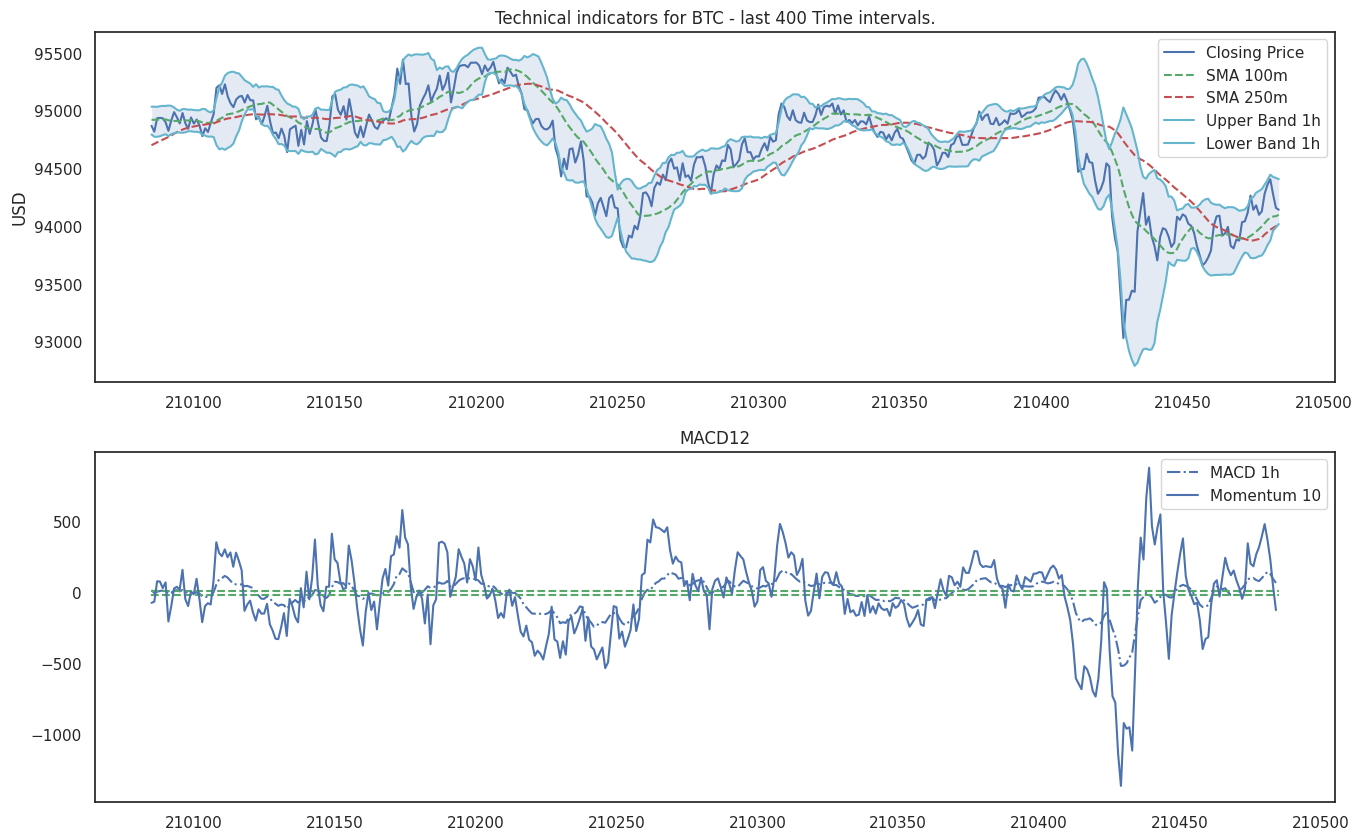

In [20]:
plot_technical_indicators(dataset_Idc,400)

In [21]:
dataset_Idc.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'pct_change', 'log_change', 'SMA3',
       'SMA12', 'SMA20', 'SMA48', 'SMA50', 'SMA288', 'EMA12', 'EMA20', 'EMA26',
       'MACD12', 'MACD24', 'RSI12', 'RSI24', 'RSI36', 'ATR12', 'ATR24',
       'ATR36', 'Upperband12', 'Lowerband12', 'Upperband24', 'Lowerband24',
       'Upperband36', 'Lowerband36', 'MOM10', 'OBV'],
      dtype='object')

# Extract Multi frequency trends

#### Create Fourier Transformed values for Close price

In [22]:
close_fft = np.fft.fft(np.asarray(dataset_Idc['close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
output_df_fft = fft_df.copy()

Do Inverse Fourier Transformation and extract Multi-Frequency trading patterns

/tmp/ipython-input-23-2985271372.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  output_df_fft[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10).astype('float')
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipython-input-23-2985271372.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  output_df_fft[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10).astype('float')
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting compl

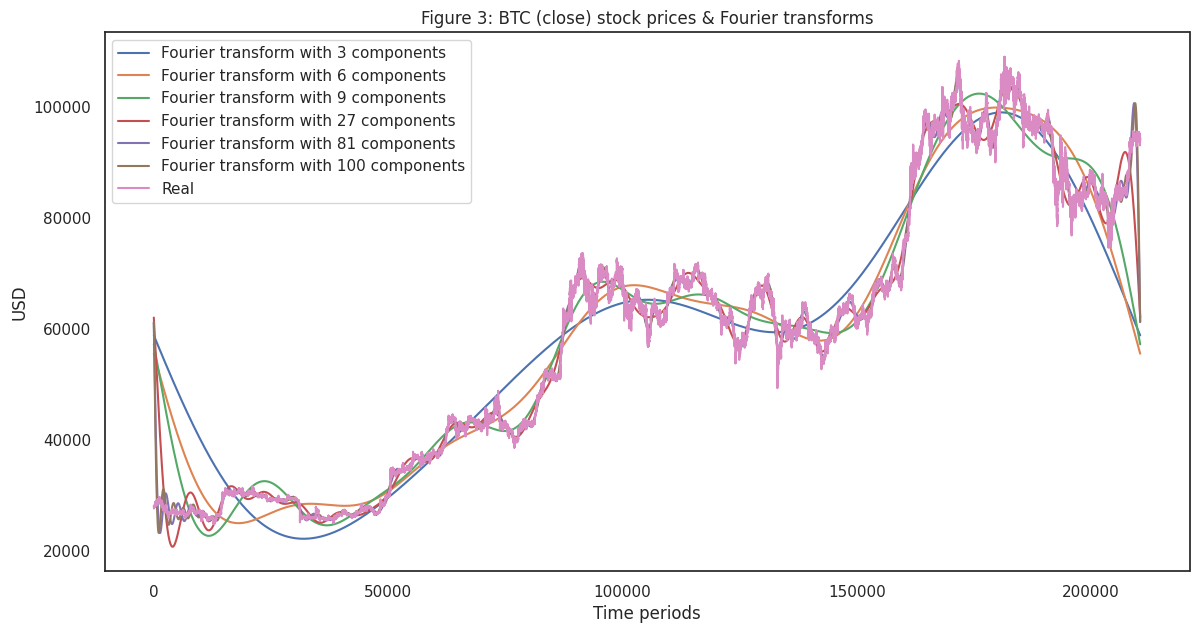

In [23]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 27, 81, 100]:
    fft_list_m10= np.copy(fft_list)
    fft_list_m10[num_:-num_]=0
    output_df_fft[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10).astype('float')
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(dataset_Idc['close'],  label='Real')
plt.xlabel('Time periods')
plt.ylabel('USD')
plt.title('Figure 3: BTC (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [24]:
output_df_fft.head()

,fft,absolute,angle,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
0,1.230423e+10+0.000000e+ 00j,1.230423e+10,0.000000,58837.134619,55544.779751,57219.448593,62039.227893,61175.296169,61228.243560
1,7.448351e+06+2.751487e+ 09j,2.751497e+09,1.568089,58835.086324,55541.695058,57214.745924,62022.974560,61125.289290,61166.214743
2,3.774556e+08+1.799923e+ 09j,1.839075e+09,1.364085,58833.038043,55538.610399,57210.043193,62006.719940,61075.285193,61104.188671
3,-6.897058e+08+5.800986e+ 08j,9.012262e+08,2.442299,58830.989775,55535.525775,57205.340400,61990.464036,61025.283971,61042.165528
4,-5.848703e+07+1.288146e+ 08j,1.414706e+08,1.997005,58828.941521,55532.441187,57200.637545,61974.206853,60975.285719,60980.145495


In [25]:
output_df_fft.shape

(210485, 9)

#### Merge Fourier transformed values & full dataset

In [26]:
df_idc_fft = pd.concat([dataset_Idc,output_df_fft[["FT_3components",	"FT_6components",	"FT_9components",	"FT_27components",	"FT_81components",	"FT_100components"]]], axis=1)
df_idc_fft

,timestamp,open,high,low,close,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,pct_change,...,Upperband36,Lowerband36,MOM10,OBV,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
0,2023-05-01 18:25:00,28206.19,28221.98,28201.38,28212.73,62.75215,1.770421e+06,28.77253,8.117083e+05,0.000232,...,28373.349607,28086.461505,-38.86,-11654.040650,58837.134619,55544.779751,57219.448593,62039.227893,61175.296169,61228.243560
1,2023-05-01 18:30:00,28212.74,28212.74,28090.71,28127.82,358.98828,1.010239e+07,158.09591,4.448396e+06,-0.003010,...,28373.623744,28085.876256,-146.09,-12013.028930,58835.086324,55541.695058,57214.745924,62022.974560,61125.289290,61166.214743
2,2023-05-01 18:35:00,28127.81,28169.01,28113.75,28169.00,156.99903,4.417774e+06,73.14579,2.058103e+06,0.001464,...,28372.034677,28089.859768,-119.20,-11856.029900,58833.038043,55538.610399,57210.043193,62006.719940,61075.285193,61104.188671
3,2023-05-01 18:40:00,28169.00,28169.01,28122.03,28128.59,123.01360,3.461668e+06,52.92906,1.489350e+06,-0.001435,...,28370.808371,28092.194407,-159.29,-11979.043500,58830.989775,55535.525775,57205.340400,61990.464036,61025.283971,61042.165528
4,2023-05-01 18:45:00,28128.58,28159.75,28119.01,28150.00,112.40453,3.162863e+06,60.65011,1.706457e+06,0.000761,...,28371.537170,28089.844497,-128.22,-11866.638970,58828.941521,55532.441187,57200.637545,61974.206853,60975.285719,60980.145495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210480,2025-04-30 18:10:00,94282.99,94441.78,94260.86,94360.00,49.00609,4.624597e+06,22.15434,2.090860e+06,0.000817,...,94318.474089,93651.222022,483.31,-15563.717071,58847.376293,55560.203738,57242.961002,62120.475114,61425.368963,61538.422454
210481,2025-04-30 18:15:00,94360.00,94461.12,94305.58,94408.05,48.89358,4.615328e+06,24.69704,2.331215e+06,0.000509,...,94358.982994,93638.213672,371.43,-15514.823491,58845.327931,55557.118871,57238.258645,62104.228276,61375.349599,61476.382642
210482,2025-04-30 18:20:00,94408.06,94449.00,94262.29,94276.00,33.41959,3.152813e+06,17.37150,1.638917e+06,-0.001399,...,94377.706737,93644.726596,232.54,-15548.243081,58843.279583,55554.034039,57233.556226,62087.980130,61325.332544,61414.344664
210483,2025-04-30 18:25:00,94276.00,94304.35,94159.82,94159.83,44.53979,4.196875e+06,14.74130,1.388818e+06,-0.001232,...,94385.485720,93653.743169,42.34,-15592.782871,58841.231248,55550.949241,57228.853744,62071.730682,61275.317890,61352.308703


In [27]:
df_idc_fft.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'pct_change', 'log_change', 'SMA3',
       'SMA12', 'SMA20', 'SMA48', 'SMA50', 'SMA288', 'EMA12', 'EMA20', 'EMA26',
       'MACD12', 'MACD24', 'RSI12', 'RSI24', 'RSI36', 'ATR12', 'ATR24',
       'ATR36', 'Upperband12', 'Lowerband12', 'Upperband24', 'Lowerband24',
       'Upperband36', 'Lowerband36', 'MOM10', 'OBV', 'FT_3components',
       'FT_6components', 'FT_9components', 'FT_27components',
       'FT_81components', 'FT_100components'],
      dtype='object')

# Optional Step - Create new features with VAE

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

#### Create dataset :  train_x, train_y, test_x, test_y

In [29]:
data = df_idc_fft.iloc[:,1:]
data.shape

(210485, 41)

In [30]:
features = data.shape[1]

In [31]:
data['y'] = data['close']

x = data.iloc[:, :features].values
y = data.iloc[:, features].values

split = int(data.shape[0]* 0.1)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (21048, 41) trainY: (21048,)
testX: (189437, 41) testY: (189437,)


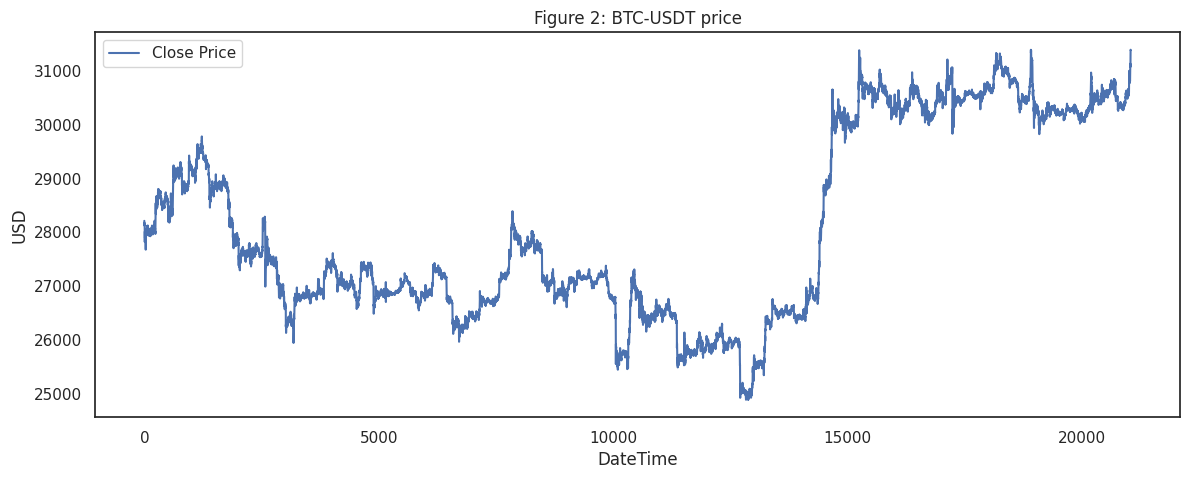

In [32]:
plotSingleCol(train_y,len(train_y),"Close Price")

#### MinMax Scalling

In [33]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))


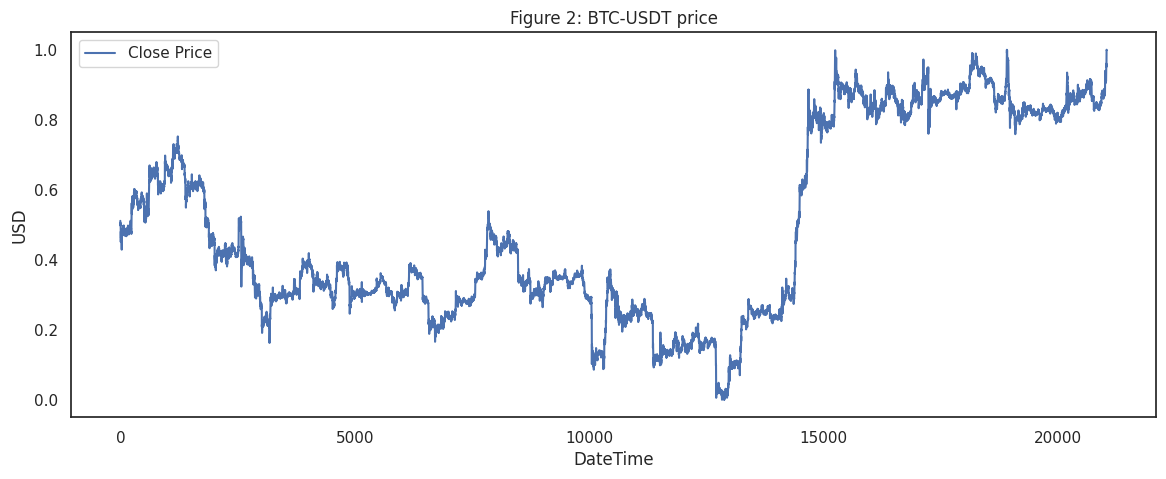

In [34]:
plotSingleCol(train_y,len(train_y),"Close Price")

In [35]:
train_x.shape

(21048, 41)

#### Implement Variational AutoEncorder

In [36]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

#### Create dataset for VAE

In [37]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
# Create dataset = (53,128,41) : num of batches, batch size, features
# 53 = 6700/128
model = VAE([features, 400, 400, 400, 10], 10)

#### Train the model

[1/50] Loss: 5638.410230636597
[2/50] Loss: 4595.469828605652
[3/50] Loss: 3293.7086811065674
[4/50] Loss: 2803.719382286072
[5/50] Loss: 2295.1233434677124
[6/50] Loss: 1873.9263229370117
[7/50] Loss: 1720.6815452575684
[8/50] Loss: 941.0583024024963
[9/50] Loss: 859.6336841583252
[10/50] Loss: 577.5527368783951
[11/50] Loss: 541.7017555236816
[12/50] Loss: 370.6397558450699
[13/50] Loss: 347.1939606666565
[14/50] Loss: 332.4482820034027
[15/50] Loss: 311.8004026412964
[16/50] Loss: 326.43107974529266
[17/50] Loss: 306.9416092634201
[18/50] Loss: 309.2974900007248
[19/50] Loss: 304.7354965209961
[20/50] Loss: 272.1719353199005
[21/50] Loss: 243.4445914030075
[22/50] Loss: 241.51383936405182
[23/50] Loss: 246.39547300338745
[24/50] Loss: 236.54561001062393
[25/50] Loss: 216.10629504919052
[26/50] Loss: 200.23245322704315
[27/50] Loss: 198.53246665000916
[28/50] Loss: 205.17592173814774
[29/50] Loss: 214.683260679245
[30/50] Loss: 223.73697078227997
[31/50] Loss: 231.55184304714203
[32/

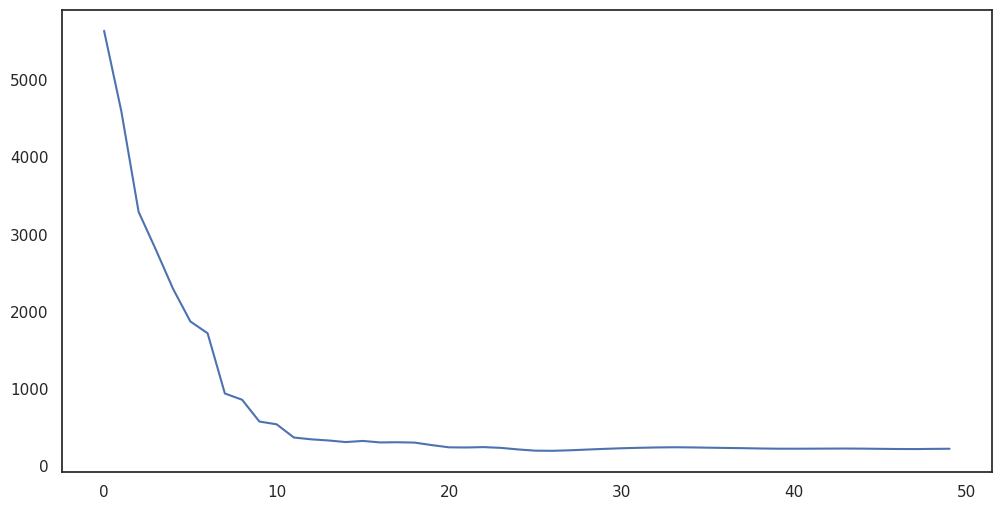

In [38]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")


num_epochs = 50
learning_rate = 0.00003
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

#### Take output

In [39]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))
print(train_x_mu.shape)
print(test_x_mu.shape)

torch.Size([21048, 10])
torch.Size([189437, 10])


In [40]:
df_tr = pd.DataFrame(VAE_train_x.detach().cpu().numpy(), columns=['enc1', 'enc2', 'enc3','enc4', 'enc5', 'enc6','enc7', 'enc8', 'enc9','enc10'])
df_ts = pd.DataFrame(VAE_test_x.detach().cpu().numpy(), columns=['enc1', 'enc2', 'enc3','enc4', 'enc5', 'enc6','enc7', 'enc8', 'enc9','enc10'])
df_ts.index += 21048

In [41]:
df_vae = pd.concat([df_tr, df_ts], axis=0)
df_vae

,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,enc10
0,1.630375,0.834921,-0.404469,0.020836,-0.140697,0.220888,1.449578,0.668810,-1.275846,-2.171069
1,-0.802825,1.189720,1.452023,0.385480,-0.923896,0.067291,-0.028099,1.022299,-0.695843,-1.007605
2,-1.109443,-0.451850,-1.962383,-0.698609,0.448942,-0.289638,-1.273018,1.271441,0.439713,1.271116
3,1.513101,-1.047260,0.586425,0.312863,-0.545463,2.270666,-1.402575,0.467980,-0.642113,-1.249068
4,0.269956,0.372082,0.781557,-0.296839,-0.061756,-1.019629,0.058528,0.069054,1.187800,-0.912994
...,...,...,...,...,...,...,...,...,...,...
210480,2.393863,-0.732129,1.442761,0.539856,-0.893403,-0.300362,1.508034,-0.073122,0.517706,0.597347
210481,0.850472,1.948928,0.343079,1.366959,-1.032847,-0.342964,-0.212466,-0.719509,1.091889,0.179484
210482,-1.636435,-1.220659,0.130840,-1.038905,1.268571,-1.052371,1.308123,-1.746087,-1.344855,-0.351123
210483,0.158376,0.149083,0.182769,-0.394396,-0.885280,-0.592209,-0.094040,1.052159,1.257324,0.282099


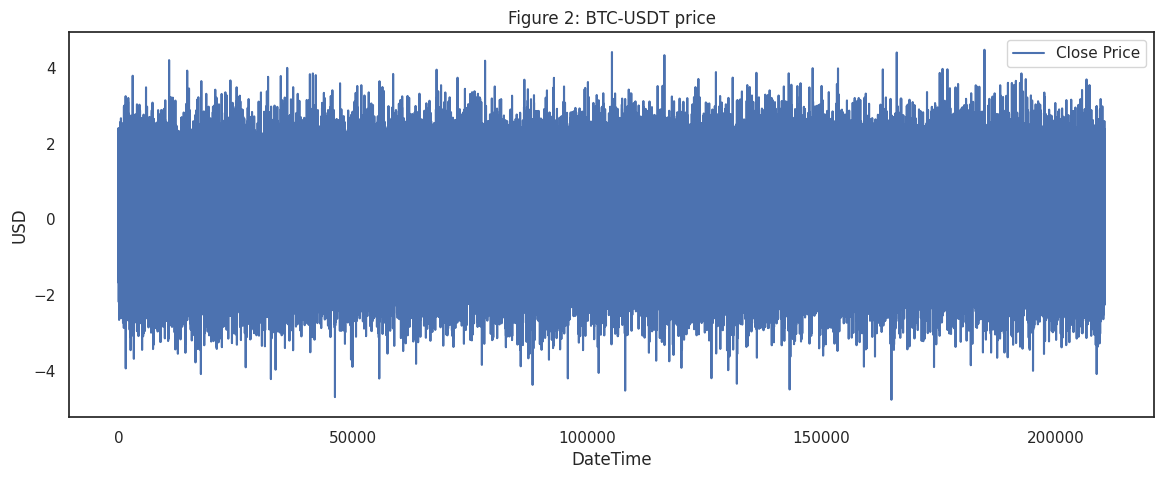

In [42]:
plotSingleCol(df_vae["enc10"],df_vae.shape[0],"Close Price")

In [43]:
df_idc_fft_vae = pd.concat([df_idc_fft, df_vae], axis=1)
df_idc_fft_vae.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,pct_change,...,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,enc10
0,2023-05-01 18:25:00,28206.19,28221.98,28201.38,28212.73,62.75215,1.770421e+06,28.77253,8.117083e+05,0.000232,...,1.630375,0.834921,-0.404469,0.020836,-0.140697,0.220888,1.449578,0.668810,-1.275846,-2.171069
1,2023-05-01 18:30:00,28212.74,28212.74,28090.71,28127.82,358.98828,1.010239e+07,158.09591,4.448396e+06,-0.003010,...,-0.802825,1.189720,1.452023,0.385480,-0.923896,0.067291,-0.028099,1.022299,-0.695843,-1.007605
2,2023-05-01 18:35:00,28127.81,28169.01,28113.75,28169.00,156.99903,4.417774e+06,73.14579,2.058103e+06,0.001464,...,-1.109443,-0.451850,-1.962383,-0.698609,0.448942,-0.289638,-1.273018,1.271441,0.439713,1.271116
3,2023-05-01 18:40:00,28169.00,28169.01,28122.03,28128.59,123.01360,3.461668e+06,52.92906,1.489350e+06,-0.001435,...,1.513101,-1.047260,0.586425,0.312863,-0.545463,2.270666,-1.402575,0.467980,-0.642113,-1.249068
4,2023-05-01 18:45:00,28128.58,28159.75,28119.01,28150.00,112.40453,3.162863e+06,60.65011,1.706457e+06,0.000761,...,0.269956,0.372082,0.781557,-0.296839,-0.061756,-1.019629,0.058528,0.069054,1.187800,-0.912994


In [44]:
df_idc_fft_vae.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'pct_change', 'log_change', 'SMA3',
       'SMA12', 'SMA20', 'SMA48', 'SMA50', 'SMA288', 'EMA12', 'EMA20', 'EMA26',
       'MACD12', 'MACD24', 'RSI12', 'RSI24', 'RSI36', 'ATR12', 'ATR24',
       'ATR36', 'Upperband12', 'Lowerband12', 'Upperband24', 'Lowerband24',
       'Upperband36', 'Lowerband36', 'MOM10', 'OBV', 'FT_3components',
       'FT_6components', 'FT_9components', 'FT_27components',
       'FT_81components', 'FT_100components', 'enc1', 'enc2', 'enc3', 'enc4',
       'enc5', 'enc6', 'enc7', 'enc8', 'enc9', 'enc10'],
      dtype='object')

In [45]:
NaNCheck(df_idc_fft_vae)

,0


Save Processed dataframe with all added features

In [46]:
df_idc_fft_vae.to_csv('/content/df_idc_fft_vae.csv', index=False)

# PCA

In [47]:
df_pca=pd.read_csv("/content/df_idc_fft_vae.csv")
df_pca.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,pct_change,...,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,enc10
0,2023-05-01 18:25:00,28206.19,28221.98,28201.38,28212.73,62.75215,1.770421e+06,28.77253,8.117083e+05,0.000232,...,1.630375,0.834921,-0.404469,0.020836,-0.140697,0.220888,1.449578,0.668810,-1.275846,-2.171069
1,2023-05-01 18:30:00,28212.74,28212.74,28090.71,28127.82,358.98828,1.010239e+07,158.09591,4.448396e+06,-0.003010,...,-0.802825,1.189720,1.452023,0.385480,-0.923896,0.067291,-0.028099,1.022299,-0.695843,-1.007605
2,2023-05-01 18:35:00,28127.81,28169.01,28113.75,28169.00,156.99903,4.417774e+06,73.14579,2.058103e+06,0.001464,...,-1.109443,-0.451850,-1.962383,-0.698609,0.448942,-0.289638,-1.273018,1.271440,0.439713,1.271116
3,2023-05-01 18:40:00,28169.00,28169.01,28122.03,28128.59,123.01360,3.461668e+06,52.92906,1.489350e+06,-0.001435,...,1.513100,-1.047260,0.586425,0.312863,-0.545463,2.270666,-1.402575,0.467980,-0.642113,-1.249068
4,2023-05-01 18:45:00,28128.58,28159.75,28119.01,28150.00,112.40453,3.162863e+06,60.65011,1.706457e+06,0.000761,...,0.269956,0.372082,0.781557,-0.296839,-0.061756,-1.019629,0.058528,0.069054,1.187800,-0.912994


In [51]:
df_ts = df_pca.copy()

In [52]:
df_pca=df_pca.drop(['timestamp'], axis=1)

In [53]:
df_pca.columns

Index(['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
       'pct_change', 'log_change', 'SMA3', 'SMA12', 'SMA20', 'SMA48', 'SMA50',
       'SMA288', 'EMA12', 'EMA20', 'EMA26', 'MACD12', 'MACD24', 'RSI12',
       'RSI24', 'RSI36', 'ATR12', 'ATR24', 'ATR36', 'Upperband12',
       'Lowerband12', 'Upperband24', 'Lowerband24', 'Upperband36',
       'Lowerband36', 'MOM10', 'OBV', 'FT_3components', 'FT_6components',
       'FT_9components', 'FT_27components', 'FT_81components',
       'FT_100components', 'enc1', 'enc2', 'enc3', 'enc4', 'enc5', 'enc6',
       'enc7', 'enc8', 'enc9', 'enc10'],
      dtype='object')

Standardizing the data

In [54]:
X = df_pca.values # matrix of dataframe
sc = StandardScaler()
X_std = sc.fit_transform(X) # standardizing the data

### Apply PCA

In [55]:
pca = PCA()
X_pca = pca.fit_transform(X_std) # fit and reduce dimensions
print(pca.n_components_)

51


Determine the number of components

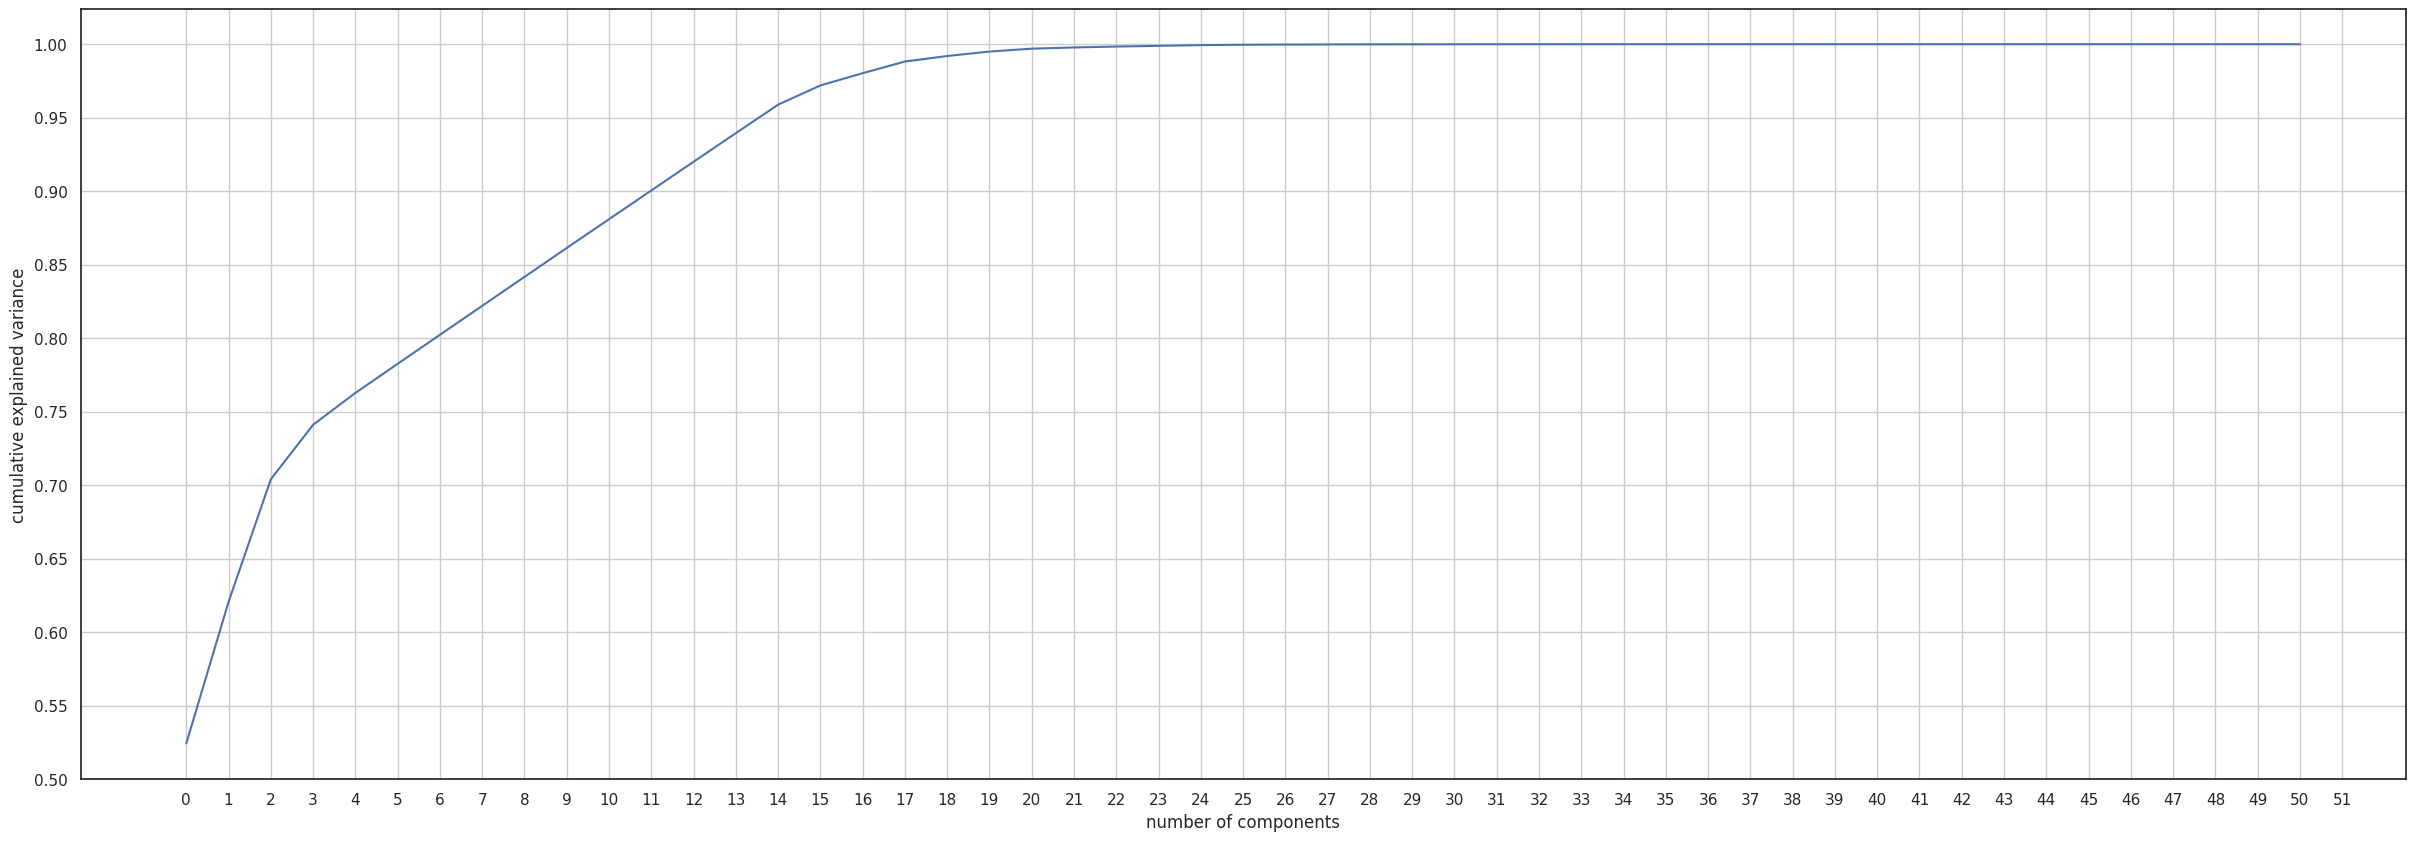

In [56]:
plt.figure(figsize=(30, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, df_pca.shape[1]+1, 1.0))
plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

Dimensionality Reduction

Select *num_components = 21*

In [57]:
num_components = 21
pca = PCA(num_components)
X_pca = pca.fit_transform(X_std) # fit and reduce dimension

In [58]:
print(df_pca.shape)
print(X_pca.shape)

(210485, 51)
(210485, 21)


Finding the most important features set

In [59]:
n_pcs= pca.n_components_ # get number of component

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = df_pca.columns

# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
for i in most_important_names:
  print(i,end="\n")

Upperband36
RSI24
volume
log_change
ATR36
enc2
enc3
enc7
enc5
enc8
enc5
enc4
enc6
enc3
enc2
MOM10
MACD24
OBV
FT_3components
taker_buy_quote_asset_volume
RSI12


In [60]:
df_PCA=X_pca.copy()
df_PCA = pd.DataFrame(df_PCA,columns=["pca1","pca2","pca3","pca4","pca5","pca6","pca7","pca8","pca9","pca10","pca11","pca12","pca13","pca14","pca15","pca16","pca17","pca18","pca19","pca20","pca21"])

In [61]:
df_PCA.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21
0,-4.728668,-1.114607,-0.365115,0.485136,0.384824,1.576102,1.213044,0.924503,0.916239,-0.297177,...,-0.098130,0.064842,-1.762032,-1.585282,0.687091,0.312060,1.402576,1.568977,0.565268,0.149354
1,-4.634006,-2.731459,1.695327,-2.316193,-0.782514,0.937458,1.450889,0.243998,0.800251,0.195880,...,-0.271979,0.968109,1.061252,-0.861825,1.033177,0.060306,1.301197,1.825314,-0.126535,0.037677
2,-4.696686,-1.201332,0.447267,1.522653,0.018328,0.077646,-1.386036,-1.748878,0.179388,1.909436,...,0.467073,-1.032296,0.349867,0.958981,0.720787,0.696833,1.348496,1.671811,0.304412,0.202355
3,-4.711780,-2.333551,0.040513,-0.850880,0.054831,-1.126004,2.241217,-1.532337,-0.238183,-0.146283,...,0.266583,0.368305,-1.706302,-1.190925,0.808154,0.286385,1.370392,1.611524,0.443190,0.128267
4,-4.715642,-1.501571,0.141052,1.013131,0.073797,1.087630,0.091214,-0.375504,-0.256254,-1.410641,...,0.112069,0.247656,0.739845,-0.029122,0.727761,0.552559,1.358777,1.638289,0.411483,0.193431


# Feature Selection

In [62]:
df=df_PCA.copy()
df["close"] = df_pca["close"]
df

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,close
0,-4.728668,-1.114607,-0.365115,0.485136,0.384824,1.576102,1.213044,0.924503,0.916239,-0.297177,...,0.064842,-1.762032,-1.585282,0.687091,0.312060,1.402576,1.568977,0.565268,0.149354,28212.73
1,-4.634006,-2.731459,1.695327,-2.316193,-0.782514,0.937458,1.450889,0.243998,0.800251,0.195880,...,0.968109,1.061252,-0.861825,1.033177,0.060306,1.301197,1.825314,-0.126535,0.037677,28127.82
2,-4.696686,-1.201332,0.447267,1.522653,0.018328,0.077646,-1.386036,-1.748878,0.179388,1.909436,...,-1.032296,0.349867,0.958981,0.720787,0.696833,1.348496,1.671811,0.304412,0.202355,28169.00
3,-4.711780,-2.333551,0.040513,-0.850880,0.054831,-1.126004,2.241217,-1.532337,-0.238183,-0.146283,...,0.368305,-1.706302,-1.190925,0.808154,0.286385,1.370392,1.611524,0.443190,0.128267,28128.59
4,-4.715642,-1.501571,0.141052,1.013131,0.073797,1.087630,0.091214,-0.375504,-0.256254,-1.410641,...,0.247656,0.739845,-0.029122,0.727761,0.552559,1.358777,1.638289,0.411483,0.193431,28150.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210480,5.720341,2.332666,-1.085728,0.302710,0.280747,-0.306216,1.024970,1.371157,-2.182308,-0.952092,...,0.254927,0.044485,-0.948348,0.567728,-0.582650,-0.757845,-2.105104,-0.837282,0.252600,94360.00
210481,5.724099,2.391343,-1.079261,-0.033009,0.232610,0.803472,0.810163,0.841489,-0.493309,-0.714150,...,1.598869,0.057586,1.468958,0.259508,-0.467614,-0.761794,-2.096745,-0.818621,0.475880,94408.05
210482,5.708456,1.105726,-1.313954,-1.566868,0.417660,-0.663835,-1.897994,1.250683,0.973522,-1.080287,...,-1.594152,0.236900,-0.619180,0.348858,-0.328672,-0.754369,-2.086100,-0.858659,0.351948,94276.00
210483,5.701965,0.308330,-1.239997,-1.324463,0.173963,1.015057,-0.048592,-0.728603,-1.085504,0.210663,...,0.385544,0.878451,-0.027912,0.270609,0.178823,-0.796799,-2.065364,-0.850515,0.355987,94159.83


In [63]:
df.isnull().sum()[df.isnull().sum()>0]

,0


In [64]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 210485 samples, and 22 features.


In [65]:
labels_df = df["close"]
features_df = df.drop(columns=["close"])

### XGBOOST

In [66]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['close']
    X = data.drop(columns=["close"])

    train_samples = int(X.shape[0] * 0.99)

    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]

    return (X_train, y_train), (X_test, y_test)

In [67]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(df)

In [68]:
X_train_FI.columns

Index(['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9',
       'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'pca16', 'pca17',
       'pca18', 'pca19', 'pca20', 'pca21'],
      dtype='object')

In [69]:
print("Shape of x_train : ",X_train_FI.shape[0],",", X_train_FI.shape[1])
print("Shape of x_test : ",X_test_FI.shape[0],",", X_test_FI.shape[1])

Shape of x_train :  208380 , 21
Shape of x_test :  2105 , 21


In [70]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [71]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [72]:
eval_result = regressor.evals_result()
eval_result

{'validation_0': OrderedDict([('rmse',
               [59756.59408041402,
                56771.26325094967,
                53935.21214815346,
                51240.91841882617,
                48681.374276678864,
                46249.755002948164,
                43939.72345261269,
                41745.18570519417,
                39660.39998609579,
                37679.82540584641,
                35798.28037896657,
                34010.88389559031,
                32312.723502070796,
                30699.58257239348,
                29167.09942479207,
                27711.274449776363,
                26328.208150056216,
                25014.223650419164,
                23766.016393386,
                22580.290448739976,
                21453.77885547919,
                20383.589539147924,
                19366.955870156788,
                18401.201586813328,
                17483.843549201796,
                16612.36229078023,
                15784.389594974382,
      

In [73]:
training_rounds = range(len(eval_result['validation_0']['rmse']))
training_rounds

range(0, 150)

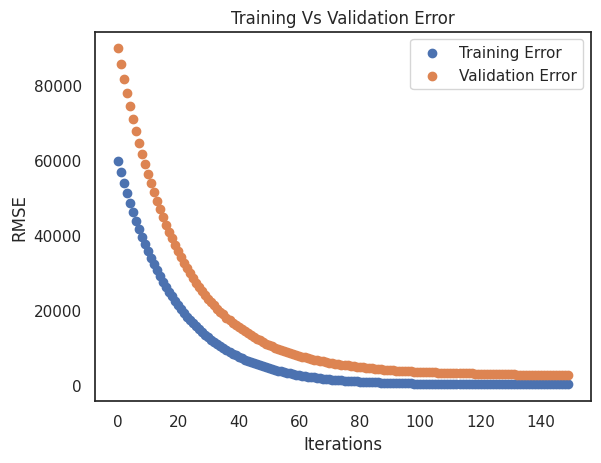

In [74]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

#### Check Feature importance

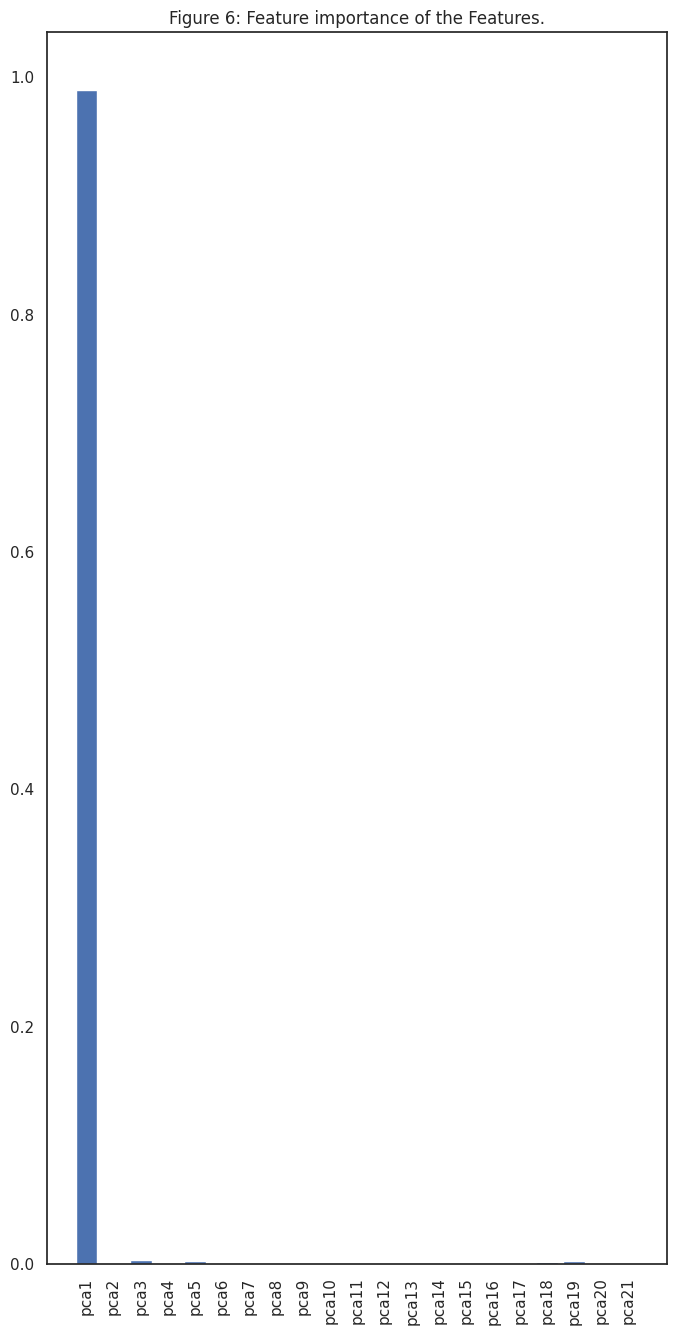

In [75]:
fig = plt.figure(figsize=(8,16))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the Features.')
plt.show()

weight: The number of times a feature is used to split the data across all trees.

gain: The average gain of the feature when it is used in a tree.

cover: The average coverage of the feature when it is used in a tree (coverage is defined as the number of samples affected by the split).

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

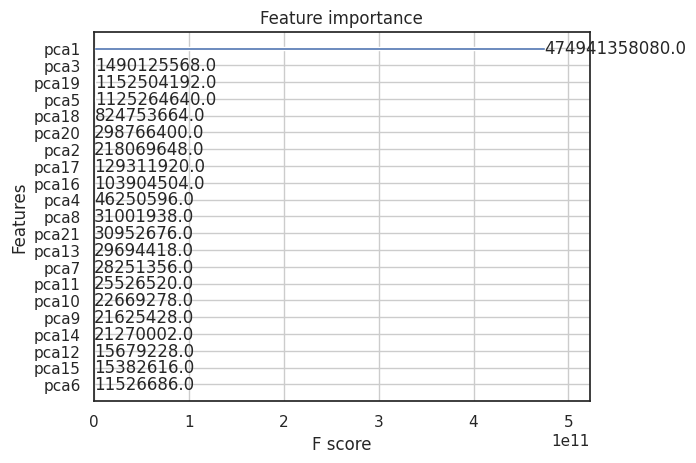

In [76]:
xgb.plot_importance(xgbModel, importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

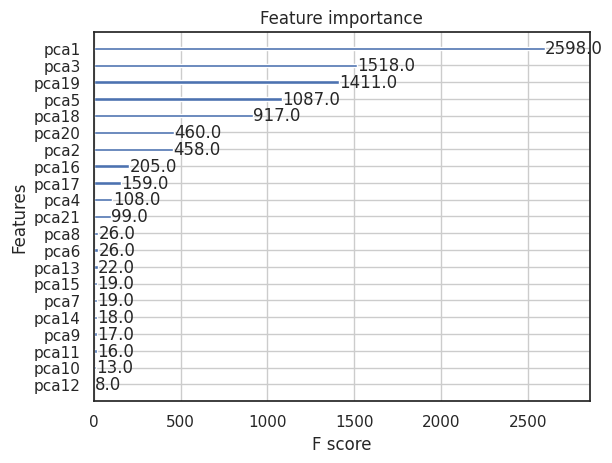

In [77]:
xgb.plot_importance(xgbModel, importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

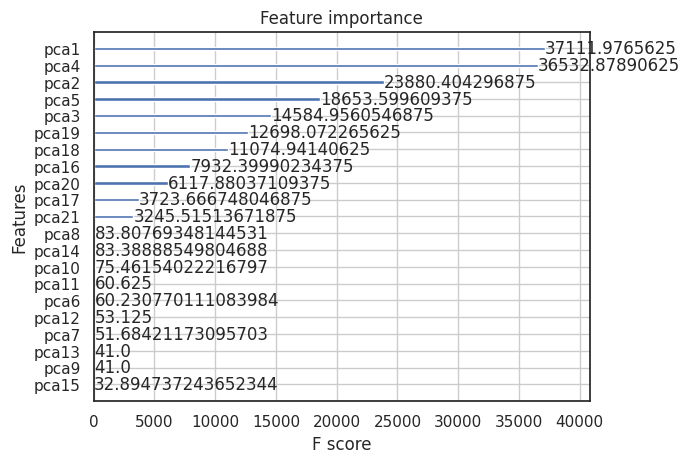

In [78]:
xgb.plot_importance(xgbModel, importance_type='cover')

In [79]:
df = df.drop(columns=["pca9","pca10","pca12","pca15"])

In [80]:
df.shape

(210485, 18)

### MI-Score

In [81]:
# labels_df = labels_df.iloc[:20000].values.reshape((20000,1))
# features_df = features_df.iloc[:20000]

In [82]:
# features_df

In [83]:
# features_df.shape

In [84]:
# labels_df.shape

In [85]:
# def make_mi_scores(X, y, discrete_features):
#     mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores


# discrete_features=features_df.dtypes == float
# mi_scores = make_mi_scores(features_df,labels_df,discrete_features)

# def plot_mi_scores(scores):
#     scores = scores.sort_values(ascending=True)
#     width = np.arange(len(scores))
#     ticks = list(scores.index)
#     plt.barh(width, scores)
#     plt.yticks(width, ticks)
#     plt.title("Mutual Information Scores")


# plt.figure(dpi=100, figsize=(8, 5))
# plot_mi_scores(mi_scores)

### Identifying Feature Correlation

<Axes: >

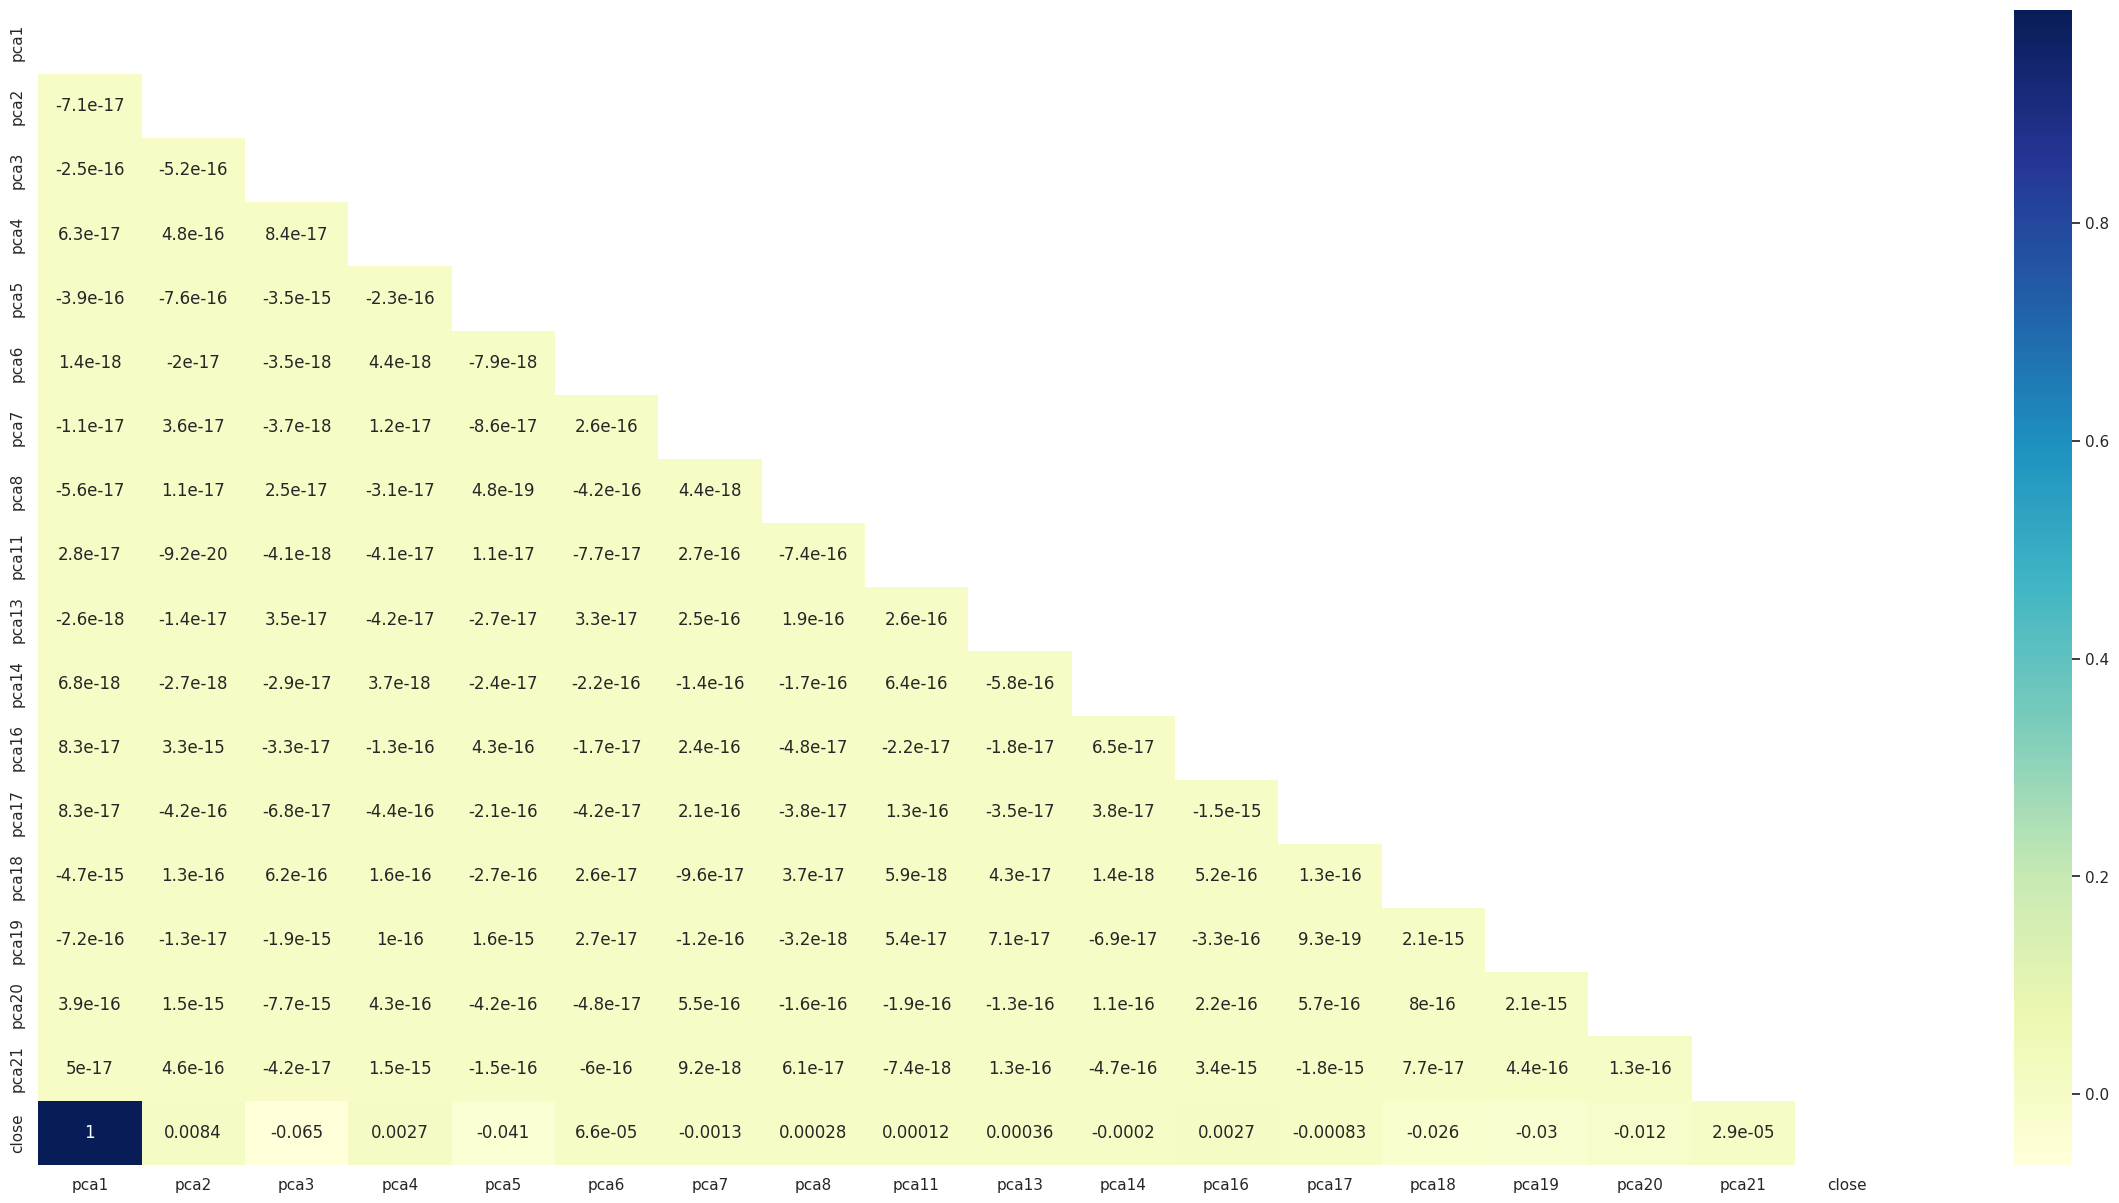

In [86]:
corr= df.corr()
matrix = np.triu(corr)

plt.figure(figsize=[30,15])
sns.heatmap(corr, annot=True, mask=matrix,cmap="YlGnBu")

# Extracting high-level features with Autoencoders

### Check Null Values

In [87]:
df.isnull().sum()[df.isnull().sum()>0]

,0


## Save CSV

In [88]:
df['timestamp'] = df_ts['timestamp']

In [89]:
df

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca11,pca13,pca14,pca16,pca17,pca18,pca19,pca20,pca21,close,timestamp
0,-4.728668,-1.114607,-0.365115,0.485136,0.384824,1.576102,1.213044,0.924503,0.821012,0.064842,-1.762032,0.687091,0.312060,1.402576,1.568977,0.565268,0.149354,28212.73,2023-05-01 18:25:00
1,-4.634006,-2.731459,1.695327,-2.316193,-0.782514,0.937458,1.450889,0.243998,-1.020911,0.968109,1.061252,1.033177,0.060306,1.301197,1.825314,-0.126535,0.037677,28127.82,2023-05-01 18:30:00
2,-4.696686,-1.201332,0.447267,1.522653,0.018328,0.077646,-1.386036,-1.748878,0.032070,-1.032296,0.349867,0.720787,0.696833,1.348496,1.671811,0.304412,0.202355,28169.00,2023-05-01 18:35:00
3,-4.711780,-2.333551,0.040513,-0.850880,0.054831,-1.126004,2.241217,-1.532337,-0.500323,0.368305,-1.706302,0.808154,0.286385,1.370392,1.611524,0.443190,0.128267,28128.59,2023-05-01 18:40:00
4,-4.715642,-1.501571,0.141052,1.013131,0.073797,1.087630,0.091214,-0.375504,0.322662,0.247656,0.739845,0.727761,0.552559,1.358777,1.638289,0.411483,0.193431,28150.00,2023-05-01 18:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210480,5.720341,2.332666,-1.085728,0.302710,0.280747,-0.306216,1.024970,1.371157,1.340495,0.254927,0.044485,0.567728,-0.582650,-0.757845,-2.105104,-0.837282,0.252600,94360.00,2025-04-30 18:10:00
210481,5.724099,2.391343,-1.079261,-0.033009,0.232610,0.803472,0.810163,0.841489,-0.118048,1.598869,0.057586,0.259508,-0.467614,-0.761794,-2.096745,-0.818621,0.475880,94408.05,2025-04-30 18:15:00
210482,5.708456,1.105726,-1.313954,-1.566868,0.417660,-0.663835,-1.897994,1.250683,-0.733345,-1.594152,0.236900,0.348858,-0.328672,-0.754369,-2.086100,-0.858659,0.351948,94276.00,2025-04-30 18:20:00
210483,5.701965,0.308330,-1.239997,-1.324463,0.173963,1.015057,-0.048592,-0.728603,0.345002,0.385544,0.878451,0.270609,0.178823,-0.796799,-2.065364,-0.850515,0.355987,94159.83,2025-04-30 18:25:00


In [90]:
df.to_csv('/content/df_pca_n_ts.csv', index=False)